# **Plot New Reward Model**

In [4]:
import os
import json
import pandas as pd
import numpy as np
import gymnasium as gym
from datetime import datetime

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import VecMonitor


In [5]:
class Data_Class:

    # Internal Class
    class Trajectory_Class:
        def __init__(self, traj_series):
            self.traj_list = traj_series
            self.length = len(traj_series)

        def get_single_traj(self, index):
            return json.loads(self.traj_list[index])

    def __init__(self, path):
        self.path = path

        # 原始数据 Original Data
        self.trajs_prefer_list = []
        self.trajs_reject_list = []

        # 处理数据 Processed Data
        self.traj_prefer_list_list_tensor = []
        self.traj_reject_list_list_tensor = []

        # 启动函数 Start Function
        self.load_data(path)
        self.convert(self.trajs_prefer_list, self.traj_prefer_list_list_tensor)   # data convert 数据转换
        self.convert(self.trajs_reject_list, self.traj_reject_list_list_tensor)
        print("Data loaded successfully")

    def load_data(self, path):
        data = pd.read_csv(path)

        self.trajs_prefer_list = Data_Class.Trajectory_Class(data['preferred'])   # list data 数据
        self.trajs_reject_list = Data_Class.Trajectory_Class(data['rejected'])    # list data 数据

    def convert(self,
                list_json: Trajectory_Class,
                traj_list_list_tensor):

        # 获取第0条轨迹的第0时刻样本来确定维度
        # Get the first sample of the first trajectory to determine dimensions
        sample = list_json.get_single_traj(0)[0]
        state0 = np.array(sample['state'])
        action0 = np.array(sample['action'])

        # 获取 state action 维度
        # Get the dimensions of state and action
        self.dim_state = state0.size if state0.ndim == 0 else state0.shape[0]
        self.dim_action = action0.size if action0.ndim == 0 else action0.shape[0]

        # 数据批量转换 tensor
        # Convert data to tensor in batches
        for idx in range(list_json.length):
            traj = list_json.get_single_traj(idx)
            states, actions = [], []

            for time_i in traj:
                # 转换为 numpy，然后 torch tensor
                # Convert to numpy, then torch tensor
                state_np = np.array(time_i['state'])
                action_np = np.array(time_i['action'])

                state_t = torch.from_numpy(state_np).float()
                action_t = torch.from_numpy(action_np).float()

                # 如果是一维标量，要展开成长度1向量
                # If it's a one-dimensional scalar, expand it into a length 1 vector
                state_t = state_t.view(-1)
                action_t = action_t.view(-1)

                states.append(state_t)
                actions.append(action_t)

            # 将列表堆成张量 [L_i, dim]
            # Stack the list into a tensor [L_i, dim]
            states_tensor = torch.stack(states, dim=0)
            actions_tensor = torch.stack(actions, dim=0)

            # 将每条轨迹作为一个元组 (states, actions) 添加到列表中
            # Add each trajectory as a tuple (states, actions) to the list
            traj_list_list_tensor.append((states_tensor, actions_tensor))

# ——— 数据集与加载器 ———
# Dataset and DataLoader
class PreferenceDataset(Dataset):
    def __init__(self, pref, rej, gamma):
        assert len(pref) == len(rej)
        self.pref = pref
        self.rej = rej
        self.gamma = gamma

    def __len__(self):
        return len(self.pref)

    def __getitem__(self, idx):
        return (*self.pref[idx], *self.rej[idx])

# MLP 打分类 
# MLP scoring model class
class RewardMLP(nn.Module):
    def __init__(self, s_dim, a_dim, hidden_dim=64):
        super().__init__()
        self.net = nn.Sequential(
            #0000FF # 这里在构造神经网络，后去可能需要调整神经网络结构 
            #0000FF # Here we construct the neural network, which may need to be adjusted later 
            nn.Linear(s_dim + a_dim, hidden_dim),  
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, s, a):
        # s: [L_i, s_dim], a: [L_i, a_dim]
        x = torch.cat([s, a], dim=-1)
        return self.net(x).squeeze(-1)



In [6]:
# ———— Hyperparameters ————
gamma = 0.99      
lr = 1e-4          
batch_size = 16
num_epochs = 50

# ———— Load Data ————
path = "trajectory_pairs.csv"
Data = Data_Class(path)

# ——— Load MLP Reward Model ———
reward_net_loaded = RewardMLP(Data.dim_state, Data.dim_action, hidden_dim=64)
reward_net_loaded.load_state_dict(torch.load('reward_net.pth', weights_only=True))
reward_net_loaded.eval()

# Load .csv Data
for i in range(10):
    traj_prefer_json = Data.trajs_prefer_list.get_single_traj(i)
    traj_reject_json = Data.trajs_reject_list.get_single_traj(i)

    # convert to tensor
    states_prefer  = torch.stack([torch.from_numpy(np.array(step['state'])).float().view(-1)
                                  for step in traj_prefer_json], dim=0)    # [L, s_dim]
    actions_prefer = torch.stack([torch.from_numpy(np.array(step['action'])).float().view(-1)
                                    for step in traj_prefer_json], dim=0)  # [L, a_dim]
    states_reject  = torch.stack([torch.from_numpy(np.array(step['state'])).float().view(-1)
                                    for step in traj_reject_json], dim=0)  # [L, s_dim]
    actions_reject = torch.stack([torch.from_numpy(np.array(step['action'])).float().view(-1)
                                    for step in traj_reject_json], dim=0)  # [L, a_dim]

    # 计算 prefer 轨迹的回报
    # Calculate the return for preferred trajectories
    with torch.no_grad():
        r_pref = reward_net_loaded(states_prefer, actions_prefer)          

    # 计算总回报
    # Calculate total return
    discounts = torch.tensor([gamma**t for t in range(r_pref.size(0))])
    total_return_prefer = (r_pref * discounts).sum()

    # 计算 reject 轨迹的回报
    # Calculate the return for rejected trajectories
    with torch.no_grad():
        r_rj = reward_net_loaded(states_reject, actions_reject)          

    # 计算总回报
    # Calculate total return
    discounts = torch.tensor([gamma**t for t in range(r_rj.size(0))])
    total_return_reject = (r_rj * discounts).sum()

    print(i, total_return_prefer, total_return_reject)



Data loaded successfully
0 tensor(12.2832) tensor(11.5129)
1 tensor(11.5982) tensor(8.9034)
2 tensor(12.5000) tensor(10.9671)
3 tensor(12.3189) tensor(10.8672)
4 tensor(12.3967) tensor(6.5947)
5 tensor(12.2223) tensor(8.9502)
6 tensor(12.2360) tensor(6.0135)
7 tensor(12.1494) tensor(5.9533)
8 tensor(11.9423) tensor(11.1330)
9 tensor(11.5264) tensor(7.4788)


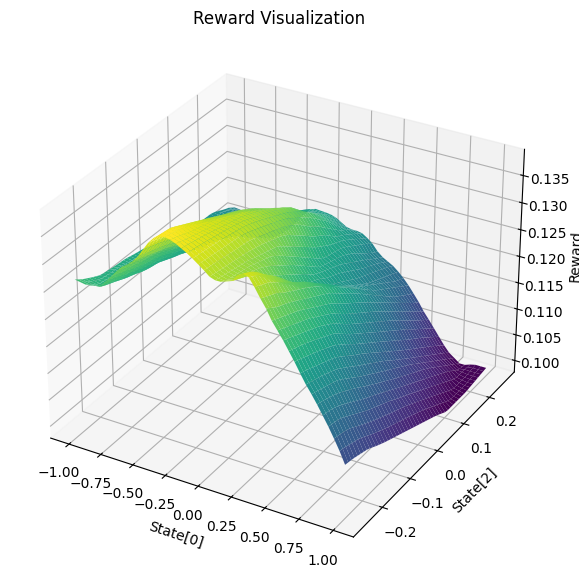

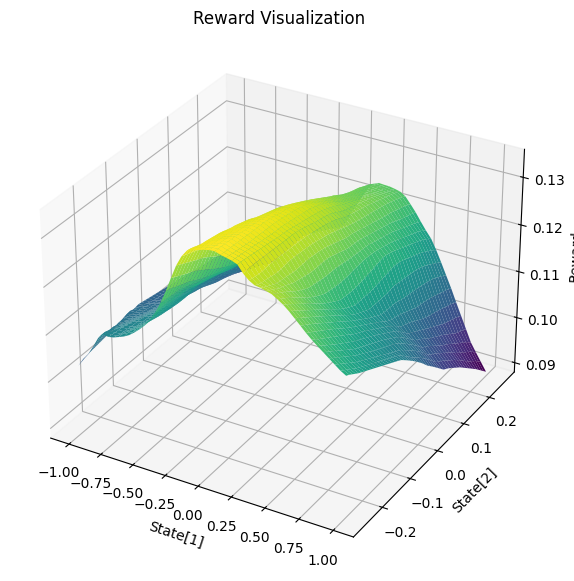

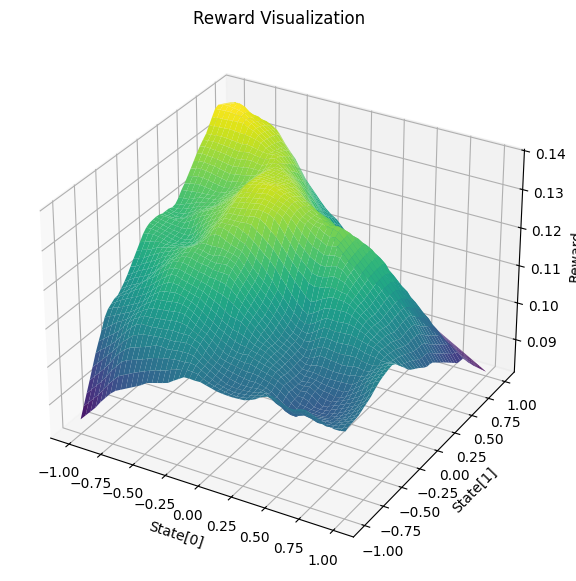

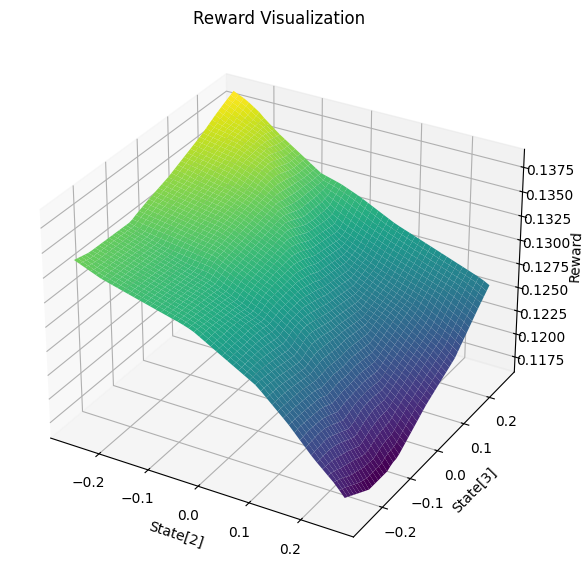

In [30]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt



def visualize_reward(reward_net, state1_range, state1_index, state2_range, state2_index):
    """
    Visualize the reward function for given state ranges and indices.

    Parameters:
    - reward_net: The reward network to evaluate.
    - state1_range: The range of values for the first state dimension.
    - state1_index: The index of the first state dimension.
    - state2_range: The range of values for the second state dimension.
    - state2_index: The index of the second state dimension.
    """
    # Create data points
    state_1_grid, state_2_grid = torch.meshgrid(state1_range, state2_range, indexing='ij')
    reward_values = torch.zeros_like(state_1_grid)

    # Compute reward
    for i in range(state_1_grid.shape[0]):
        for j in range(state_1_grid.shape[1]):
            # Construct state and action
            state = torch.zeros(Data.dim_state)
            state[state1_index] = state_1_grid[i, j]
            state[state2_index] = state_2_grid[i, j]
            action = torch.zeros(Data.dim_action)

            # Compute reward
            with torch.no_grad():
                reward_values[i, j] = reward_net(state.view(1, -1), action.view(1, -1))

    # Plot 3D graph
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')

    ax.plot_surface(state_1_grid.numpy(), state_2_grid.numpy(), reward_values.numpy(), cmap='viridis')
    ax.set_xlabel(f'State[{state1_index}]')
    ax.set_ylabel(f'State[{state2_index}]')
    ax.set_zlabel('Reward')
    ax.set_title('Reward Visualization')
    plt.show()


X         = 0
X_DOT     = 1
THETA     = 2
THETA_DOT = 3
visualize_reward(reward_net_loaded,
                  state1_range=torch.linspace(-1, 1, 50),
                  state1_index=X,
                  state2_range=torch.linspace(-np.deg2rad(15), +np.deg2rad(15), 50),
                  state2_index=THETA)

visualize_reward(reward_net_loaded,
                  state1_range=torch.linspace(-1, 1, 50),
                  state1_index=X_DOT,
                  state2_range=torch.linspace(-np.deg2rad(15), +np.deg2rad(15), 50),
                  state2_index=THETA)

visualize_reward(reward_net_loaded,
                  state1_range=torch.linspace(-1, 1, 50),
                  state1_index=X,
                  state2_range=torch.linspace(-1, 1, 50),
                  state2_index=X_DOT)

visualize_reward(reward_net_loaded,
                  state1_range=torch.linspace(-np.deg2rad(15), +np.deg2rad(15), 50),
                  state1_index=THETA,
                  state2_range=torch.linspace(-np.deg2rad(15), +np.deg2rad(15), 50),
                  state2_index=THETA_DOT)